In [1]:
import csv
import random
import datetime

# --- Configuration ---
NUM_CONSUMERS = 5000
NUM_MONTHS = 36
BUILDING_TYPES = ["corner_house", "middle-row_house", "bungalow", "townhouse"]
OUTPUT_CSV_FILE = "energy_usage.csv"
START_YEAR = 2022 # The starting year for the data generation


def generate_monthly_usage(building_type):
    """
    Generates more realistic monthly energy usage (in kWh) based on building type.
    """
    # Updated base usage values to be more realistic (800-1100 kWh range)
    base_usage = {
        "bungalow": 1100,
        "corner_house": 950,
        "townhouse": 850,
        "middle-row_house": 800
    }
    # Increased random variation for more realism
    return base_usage[building_type] + random.uniform(-100, 100)

def create_csv_data():
    """Generates the consumer data and writes it to a CSV file."""
    header = ['consumer_id', 'postcode', 'building_type', 'month', 'monthly_usage']

    with open(OUTPUT_CSV_FILE, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)

        for i in range(1, NUM_CONSUMERS + 1):
            consumer_id = f"CID{i:04d}"
            postcode = random.randint(51000, 52000)
            building_type = random.choice(BUILDING_TYPES)
            
            low_usage_months = random.sample(range(12), 9)

            for j in range(NUM_MONTHS):
                year = START_YEAR + j // 12
                month_num = 1 + j % 12
                month_str = datetime.date(year, month_num, 1).strftime('%b%Y')
                
                usage = generate_monthly_usage(building_type)

                writer.writerow([consumer_id, postcode, building_type, month_str, round(usage, 2)])

    print(f"Successfully generated '{OUTPUT_CSV_FILE}' with realistic data.")

if __name__ == "__main__":
    create_csv_data()


Successfully generated 'energy_usage.csv' with realistic data.


In [2]:
import csv
import random
import datetime

# --- Configuration ---
NUM_CONSUMERS = 500
NUM_MONTHS = 36
BUILDING_TYPES = ["corner_house", "middle-row_house", "bungalow", "townhouse"]
OUTPUT_CSV_FILE = "checklist.csv"
START_YEAR = 2022 # The starting year for the data generation

# --- Fraud Simulation Configuration ---
# The following consumer IDs will be flagged for low-usage fraud simulation.
LOW_USAGE_FRAUD_IDS = ["CID0015", "CID0035", "CID0055", "CID0075", "CID0095"]

def generate_monthly_usage(building_type):
    """
    Generates more realistic monthly energy usage (in kWh) based on building type.
    """
    # Updated base usage values to be more realistic (800-1100 kWh range)
    base_usage = {
        "bungalow": 1100,
        "corner_house": 950,
        "townhouse": 850,
        "middle-row_house": 800
    }
    # Increased random variation for more realism
    return base_usage[building_type] + random.uniform(-100, 100)

def create_csv_data():
    """Generates the consumer data and writes it to a CSV file."""
    header = ['consumer_id', 'postcode', 'building_type', 'month', 'monthly_usage']
    
    print(f"Generating data with low-usage fraud simulation for IDs: {LOW_USAGE_FRAUD_IDS}")

    with open(OUTPUT_CSV_FILE, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)

        for i in range(1, NUM_CONSUMERS + 1):
            consumer_id = f"CID{i:04d}"
            postcode = random.randint(51000, 52000)
            building_type = random.choice(BUILDING_TYPES)
            
            low_usage_months = random.sample(range(12), 9)

            for j in range(NUM_MONTHS):
                year = START_YEAR + j // 12
                month_num = 1 + j % 12
                month_str = datetime.date(year, month_num, 1).strftime('%b%Y')
                
                usage = generate_monthly_usage(building_type)
                
                if consumer_id in LOW_USAGE_FRAUD_IDS and j in low_usage_months:
                    usage *= random.uniform(0.1, 0.25) 

                writer.writerow([consumer_id, postcode, building_type, month_str, round(usage, 2)])

    print(f"Successfully generated '{OUTPUT_CSV_FILE}' with realistic data.")

if __name__ == "__main__":
    create_csv_data()


Generating data with low-usage fraud simulation for IDs: ['CID0015', 'CID0035', 'CID0055', 'CID0075', 'CID0095']
Successfully generated 'checklist.csv' with realistic data.


In [3]:
import pandas as pd
import pickle

# --- Configuration ---
INPUT_CSV_FILE = "energy_usage.csv" 
MODEL_OUTPUT_FILE = "fraud-model.pkl"

def prepare_community_data():
    """
    This script calculates the "normal" average consumption for each community
    based on the input data and saves it for the detection script.
    No logical changes are needed as it adapts to the new realistic data.
    """
    print("Starting community data preparation...")

    # Load the dataset
    try:
        df = pd.read_csv(INPUT_CSV_FILE)
        print(f"Successfully loaded '{INPUT_CSV_FILE}'.")
    except FileNotFoundError:
        print(f"Error: The file '{INPUT_CSV_FILE}' was not found.")
        print("Please run the data generation script first.")
        return

    # --- Calculate Community Norms ---
    print("Calculating community consumption norms...")
    community_stats = df.groupby(['postcode', 'building_type']).agg(
        community_avg_usage=('monthly_usage', 'mean')
    ).reset_index()
    print("Calculation complete.")

    # --- Save the Community Stats ---
    with open(MODEL_OUTPUT_FILE, 'wb') as f:
        pickle.dump(community_stats, f)

    print(f"\nCommunity stats successfully saved to '{MODEL_OUTPUT_FILE}'.")
    print("\n--- Community Stats Summary (First 5) ---")
    print(community_stats.head())
    print("-------------------------------------------")


if __name__ == "__main__":
    prepare_community_data()


Starting community data preparation...
Successfully loaded 'energy_usage.csv'.
Calculating community consumption norms...
Calculation complete.

Community stats successfully saved to 'fraud-model.pkl'.

--- Community Stats Summary (First 5) ---
   postcode     building_type  community_avg_usage
0     51000          bungalow          1099.782500
1     51000         townhouse           844.942778
2     51001          bungalow          1102.599444
3     51001  middle-row_house           805.128194
4     51002         townhouse           859.962778
-------------------------------------------


In [4]:
import pandas as pd
import pickle

# --- Configuration ---
STATS_INPUT_FILE = "fraud-model.pkl"
DATA_SOURCE_FILE = "checklist.csv" 

def detect_consumer_fraud(consumer_data, community_stats):
    """
    Analyzes 12 months of a consumer's usage data using a hard business rule.

    Args:
        consumer_data (pd.DataFrame): 12 months of data for one consumer.
        community_stats (pd.DataFrame): The pre-calculated community average usages.

    Returns:
        tuple[str, float]: A tuple containing the prediction result ("Fraudulent" or "Not Fraudulent")
                           and the consumer's usage as a percentage of the community normal.
    """
    # --- Prepare Consumer Data ---
    postcode = consumer_data['postcode'].iloc[0]
    building_type = consumer_data['building_type'].iloc[0]
    avg_monthly_usage = consumer_data['monthly_usage'].mean()

    # --- Find the community average from the loaded stats ---
    stats = community_stats[
        (community_stats['postcode'] == postcode) & 
        (community_stats['building_type'] == building_type)
    ]
    
    if stats.empty:
        return "Cannot determine", 0.0

    community_avg = stats['community_avg_usage'].iloc[0]
    
    # --- Apply the 30% Rule ---
    # Fraud is defined as usage that is 30% lower than the community average.
    # This means their usage is less than 70% of the normal average.
    fraud_threshold = community_avg * 0.70
    
    # Calculate how the consumer's usage compares to the norm, for reporting.
    percentage_of_normal = (avg_monthly_usage / community_avg) * 100 if community_avg > 0 else 0

    if avg_monthly_usage < fraud_threshold:
        return "Fraudulent", round(percentage_of_normal, 2)
    else:
        return "Not Fraudulent", round(percentage_of_normal, 2)

if __name__ == '__main__':
    # --- Main Execution: Analyze the entire checklist.csv file ---
    print("--- Rule-Based Fraud Detection ---")
    
    # --- Load the Community Stats (our new "model") ---
    try:
        with open(STATS_INPUT_FILE, 'rb') as f:
            community_stats = pickle.load(f)
        print(f"Successfully loaded community stats from '{STATS_INPUT_FILE}'.")
    except FileNotFoundError:
        print(f"Error: Stats file '{STATS_INPUT_FILE}' not found. Please run the preparation script first.")
        exit()

    # --- FIX: Handle both old (dict) and new (DataFrame) model file formats ---
    if isinstance(community_stats, dict):
        print("Info: Old model format detected. Extracting community_stats DataFrame.")
        community_stats = community_stats['community_stats']

    # --- FIX: Ensure 'postcode' is a column, not an index ---
    if 'postcode' not in community_stats.columns:
        print("Info: 'postcode' not in columns. Attempting to reset index...")
        community_stats = community_stats.reset_index()

    # Load the consumer data
    try:
        full_df = pd.read_csv(DATA_SOURCE_FILE)
    except FileNotFoundError:
        print(f"Error: Data source file '{DATA_SOURCE_FILE}' not found.")
        exit()

    all_consumer_ids = full_df['consumer_id'].unique()
    fraud_report = []

    print(f"Analyzing {len(all_consumer_ids)} unique consumers with the 30% rule...")
    
    for consumer_id in all_consumer_ids:
        consumer_data = full_df[full_df['consumer_id'] == consumer_id].head(12)
        
        if len(consumer_data) == 12:
            result, percentage = detect_consumer_fraud(consumer_data, community_stats)
            
            if result == "Fraudulent":
                fraud_report.append({
                    "id": consumer_id,
                    "avg_usage": consumer_data['monthly_usage'].mean(),
                    "percent_of_normal": percentage
                })

    # --- Print the Final Report ---
    print("\n--- Low-Usage Fraud Detection Report ---")
    if fraud_report:
        num_fraudulent = len(fraud_report)
        total_consumers = len(all_consumer_ids)
        fraud_percentage = (num_fraudulent / total_consumers) * 100 if total_consumers > 0 else 0

        print(f"Found {num_fraudulent} consumers with usage <70% of their community normal.")
        print(f"This represents {fraud_percentage:.2f}% of the total consumers analyzed.")
        
        report_df = pd.DataFrame(fraud_report).sort_values(by='percent_of_normal')
        report_df = report_df.set_index('id')
        print(report_df.round(2))
    else:
        print("No consumers met the criteria for low-usage fraud.")
    print("----------------------------------------")


--- Rule-Based Fraud Detection ---
Successfully loaded community stats from 'fraud-model.pkl'.
Analyzing 500 unique consumers with the 30% rule...

--- Low-Usage Fraud Detection Report ---
Found 3 consumers with usage <70% of their community normal.
This represents 0.60% of the total consumers analyzed.
         avg_usage  percent_of_normal
id                                   
CID0095     312.81              36.46
CID0075     327.59              38.38
CID0015     313.84              39.11
----------------------------------------


--- Starting Fraud Visualization ---
Data analysis complete. Generating graph...

Graph successfully saved to 'fraud_visualization.png'.


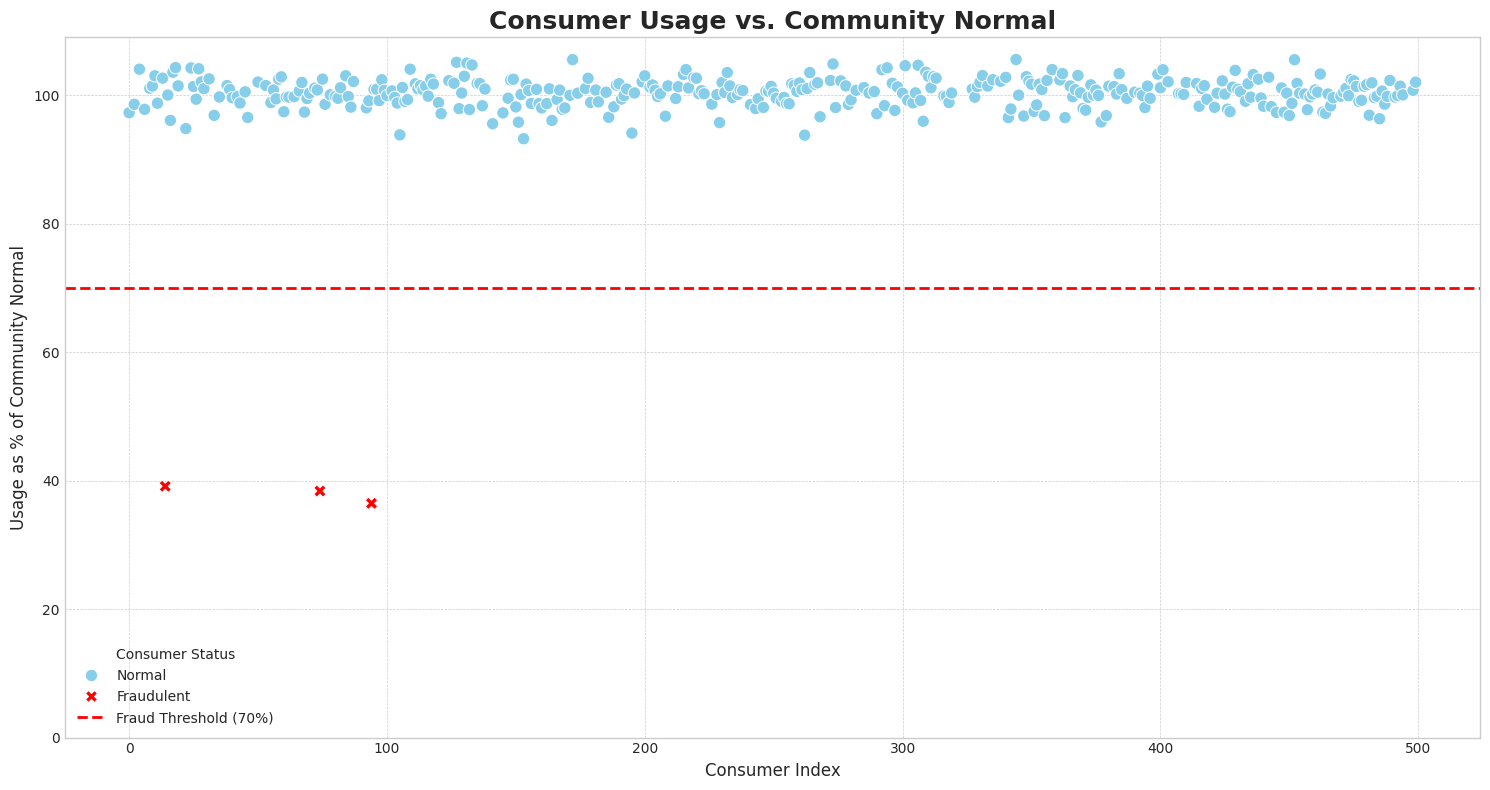

In [5]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
STATS_INPUT_FILE = "fraud-model.pkl"
DATA_SOURCE_FILE = "checklist.csv" 
OUTPUT_GRAPH_FILE = "fraud_visualization.png"

def create_fraud_visualization():
    """
    Analyzes all consumers, identifies fraudulent ones based on the rule,
    and generates a scatter plot to visualize their position as outliers.
    """
    print("--- Starting Fraud Visualization ---")

    # --- Load Data and Stats ---
    try:
        with open(STATS_INPUT_FILE, 'rb') as f:
            community_stats = pickle.load(f)
        full_df = pd.read_csv(DATA_SOURCE_FILE)
    except FileNotFoundError as e:
        print(f"Error: Could not find a required file. {e}")
        print("Please ensure 'checklist.csv' and 'fraud-model.pkl' exist.")
        return

    # --- Data Preparation ---
    # Calculate average usage for the first 12 months for every consumer
    consumer_avg_usage = full_df.groupby('consumer_id').head(12).groupby('consumer_id').agg(
        postcode=('postcode', 'first'),
        building_type=('building_type', 'first'),
        avg_monthly_usage=('monthly_usage', 'mean')
    ).reset_index()

    # Merge with community stats to get the 'normal' average
    analysis_df = pd.merge(consumer_avg_usage, community_stats, on=['postcode', 'building_type'], how='left')

    # Calculate the percentage of normal usage for each consumer
    analysis_df['percent_of_normal'] = (
        (analysis_df['avg_monthly_usage'] / analysis_df['community_avg_usage']) * 100
    )

    # Define a function to apply status, handling missing community data
    def assign_status(percent):
        if pd.isna(percent):
            return 'Unknown'
        elif percent < 70:
            return 'Fraudulent'
        else:
            return 'Normal'

    # Apply the status logic
    analysis_df['status'] = analysis_df['percent_of_normal'].apply(assign_status)
    
    # --- Filter out Unknown data points before plotting ---
    plot_df = analysis_df[analysis_df['status'] != 'Unknown'].copy()

    print("Data analysis complete. Generating graph...")

    # --- Graph Generation ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 8))

    # Create the scatter plot using the filtered DataFrame
    sns.scatterplot(
        data=plot_df,
        x=plot_df.index,
        y='percent_of_normal',
        hue='status',
        palette={'Normal': 'skyblue', 'Fraudulent': 'red'},
        style='status',
        s=80,
        ax=ax
    )

    # Add a horizontal line for the fraud threshold
    ax.axhline(y=70, color='r', linestyle='--', linewidth=2, label='Fraud Threshold (70%)')

    # Formatting the graph
    ax.set_title('Consumer Usage vs. Community Normal', fontsize=18, fontweight='bold')
    ax.set_xlabel('Consumer Index', fontsize=12)
    ax.set_ylabel('Usage as % of Community Normal', fontsize=12)
    ax.legend(title='Consumer Status')
    ax.set_ylim(bottom=0) # Start y-axis at 0
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    
    # Save the graph to a file
    plt.savefig(OUTPUT_GRAPH_FILE)
    print(f"\nGraph successfully saved to '{OUTPUT_GRAPH_FILE}'.")


if __name__ == '__main__':
    create_fraud_visualization()


In [6]:
import pandas as pd
import pickle
import folium
import random

# --- Configuration ---
STATS_INPUT_FILE = "fraud-model.pkl"
DATA_SOURCE_FILE = "checklist.csv" 

def get_mock_coordinates(postcode):
    """
    Generates mock latitude/longitude coordinates based on Kuala Lumpur postcode ranges.
    In a real-world scenario, you would use a proper geocoding API.
    """
    # Define some rough bounding boxes for different parts of Kuala Lumpur
    # to simulate geographic distribution.
    postcode_regions = {
        (51000, 51250): {'lat': (3.15, 3.20), 'lon': (101.67, 101.72)}, # KL City Centre / Ampang
        (51251, 51500): {'lat': (3.05, 3.10), 'lon': (101.70, 101.75)}, # South (e.g., Cheras, Sungai Besi)
        (51501, 51750): {'lat': (3.18, 3.23), 'lon': (101.60, 101.65)}, # North (e.g., Kepong, Sentul)
        (51751, 52000): {'lat': (3.10, 3.15), 'lon': (101.60, 101.65)}, # West (e.g., Damansara, Bangsar)
    }

    for (start, end), coords in postcode_regions.items():
        if start <= postcode <= end:
            # Return a random point within the defined box to avoid marker overlap
            return (random.uniform(*coords['lat']), random.uniform(*coords['lon']))
    
    # Fallback for any postcodes outside the defined ranges
    return (3.1390, 101.6869) # Default to central Kuala Lumpur

def create_fraud_map():
    """
    Analyzes all consumers, identifies fraudulent ones, and generates an
    interactive HTML map to visualize their geographic locations.
    """
    print("--- Starting Fraud Map Visualization ---")

    # --- Load Data and Stats ---
    try:
        with open(STATS_INPUT_FILE, 'rb') as f:
            community_stats = pickle.load(f)
        full_df = pd.read_csv(DATA_SOURCE_FILE)
    except FileNotFoundError as e:
        print(f"Error: Could not find a required file. {e}")
        return None

    # --- Data Preparation ---
    consumer_avg_usage = full_df.groupby('consumer_id').head(12).groupby('consumer_id').agg(
        postcode=('postcode', 'first'),
        building_type=('building_type', 'first'),
        avg_monthly_usage=('monthly_usage', 'mean')
    ).reset_index()

    # Merge with community stats to get the 'normal' average
    analysis_df = pd.merge(consumer_avg_usage, community_stats, on=['postcode', 'building_type'], how='left')
    
    analysis_df['percent_of_normal'] = ((analysis_df['avg_monthly_usage'] / analysis_df['community_avg_usage']) * 100).fillna(100)
    analysis_df['status'] = analysis_df['percent_of_normal'].apply(lambda x: 'Fraudulent' if x < 70 else 'Normal')
    
    print("Data analysis complete. Generating map...")

    # --- Map Generation ---
    # Create a base map centered on Kuala Lumpur
    kl_map = folium.Map(location=[3.1390, 101.6869], zoom_start=11)

    # Create feature groups to allow toggling layers
    normal_group = folium.FeatureGroup(name='Normal Consumers').add_to(kl_map)
    fraud_group = folium.FeatureGroup(name='Fraudulent Consumers').add_to(kl_map)

    # Iterate through each consumer to plot them on the map
    for _, row in analysis_df.iterrows():
        coords = get_mock_coordinates(row['postcode'])
        popup_text = f"""
            <b>Consumer ID:</b> {row['consumer_id']}<br>
            <b>Status:</b> {row['status']}<br>
            <b>Avg. Usage:</b> {row['avg_monthly_usage']:.2f} kWh<br>
            <b>Usage vs Normal:</b> {row['percent_of_normal']:.2f}%
        """
        
        if row['status'] == 'Fraudulent':
            folium.Marker(
                location=coords,
                popup=popup_text,
                icon=folium.Icon(color='red', icon='exclamation-sign')
            ).add_to(fraud_group)
        else:
            folium.Marker(
                location=coords,
                popup=popup_text,
                icon=folium.Icon(color='blue', icon='info-sign')
            ).add_to(normal_group)
            
    # Add a layer control panel to the map
    folium.LayerControl().add_to(kl_map)

    print("\nMap generation complete. Displaying map below.")
    # Return the map object to be displayed in the Jupyter cell
    return kl_map


if __name__ == '__main__':
    # When run as a script, this will create and return the map object.
    # In a Jupyter Notebook, calling create_fraud_map() will display the map.
    fraud_map = create_fraud_map()
    # To display in a notebook, simply have `fraud_map` as the last line of the cell.
    #fraud_map 


--- Starting Fraud Map Visualization ---
Data analysis complete. Generating map...

Map generation complete. Displaying map below.


In [ ]:
fraud_map